# Testing Notebook for Rodent Env

In [1]:
%load_ext autoreload
%autoreload 2

from vnl_playground.tasks.rodent import base as rodent_base
from vnl_playground.tasks.rodent import flat_arena
from vnl_playground.tasks.mouse import mouse_reach
from mujoco_playground._src.locomotion.go1 import base as go1_base
import mujoco as mj
import mediapy as media
import jax
from jax import numpy as jp

import os

xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MUJOCO_GL"] = "egl"

In [2]:
env = mouse_reach.MouseEnv()
state = env.reset(jax.random.PRNGKey(0))

In [ ]:
# Add a target to the environment
target_position = (0.004, 0.012, -0.006)  # Position close to where the wrist might reach
env.add_target(pos=target_position)
print(f"Added target at position: {target_position}")

# Reset the environment after adding the target
state = env.reset(jax.random.PRNGKey(0))

In [ ]:
state = env.step(state, jp.zeros(env.action_size))

Array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-9.9999997e-05, -9.9999997e-05,  5.0000002e-04],
       [-4.8236187e-05,  4.0962518e-04, -1.7303217e-05],
       [ 1.1888965e-03, -4.1380441e-03, -4.9537215e-03],
       [ 1.1888965e-03, -4.1380441e-03, -4.9537215e-03],
       [ 1.5080238e-03, -3.8207928e-03, -4.9506365e-03],
       [ 3.0526111e-04, -3.4860242e-04, -1.0694963e-02]], dtype=float32)

In [ ]:
state.data.xpos

Array([ 0.00030526, -0.0003486 , -0.01069496], dtype=float32)

In [ ]:
# Get wrist body position
wrist_body = state.data.bind(env.mjx_model, env._spec.body("wrist_body"))
wrist_pos = wrist_body.xpos
print(f"Wrist position: {wrist_pos}")

# Get target position
target_pos = env._target_position
print(f"Target position: {target_pos}")

# Calculate distance between wrist and target
dist = jp.linalg.norm(wrist_pos - target_pos)
print(f"Distance to target: {dist:.6f}m")

In [7]:
from mujoco_playground._src import reward

Current wrist to target distance: 0.020700
Target size: 0.001000


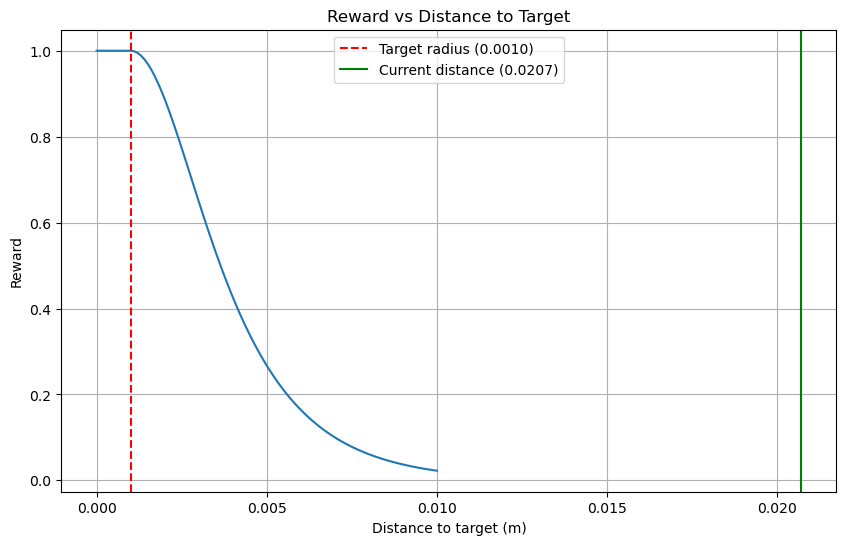

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get the wrist body position from state
wrist_body = state.data.bind(env.mjx_model, env._spec.body("wrist_body"))
wrist_pos = wrist_body.xpos

# Get target position from the environment (set during add_target)
target_pos = env._target_position

# Get the target size from the environment
target_size = env._target_size

# Calculate current distance between wrist and target
current_dist = jp.linalg.norm(wrist_pos - target_pos)
print(f"Current wrist to target distance: {current_dist:.6f}m")
print(f"Target size: {target_size:.6f}m")

# Calculate current reward
current_reward = reward.tolerance(current_dist, (0, target_size), margin=0.006, sigmoid="hyperbolic")
print(f"Current reward: {current_reward:.6f}")

# Generate distance values and compute rewards
max_dist = float(current_dist) * 2  # Scale based on current distance
dist_values = np.linspace(0, max_dist, 100)  
reward_values = [
    reward.tolerance(x, (0, target_size), margin=0.006, sigmoid="hyperbolic")
    for x in dist_values
]

plt.figure(figsize=(10, 6))
plt.plot(dist_values, reward_values)
plt.axvline(x=target_size, color='r', linestyle='--', label=f'Target radius ({target_size:.6f}m)')
plt.axvline(x=current_dist, color='g', linestyle='-', label=f'Current distance ({current_dist:.6f}m)')
plt.xlabel("Distance to target (m)")
plt.ylabel("Reward")
plt.title("Reward vs Distance to Target")
plt.legend()
plt.grid()
plt.show()

In [15]:
state.data.bind(env.mjx_model, env._spec.body("wrist_body")).xpos

Array([ 0.00030526, -0.0003486 , -0.01069496], dtype=float32)

In [ ]:
def render(model, data=None, height=300, camera=-1):
    if data is None:
        data = mj.MjData(model)
    with mj.Renderer(model, 480, 640) as renderer:
        mj.mj_forward(model, data)
        renderer.update_scene(data, camera=camera)
        media.show_image(renderer.render(), height=height)

""

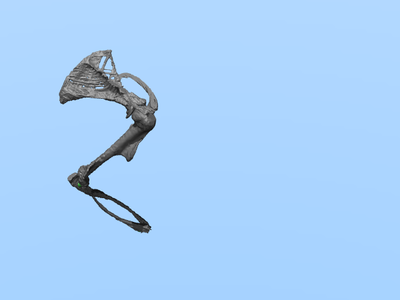

In [55]:
render(env.mj_model, camera="close_profile")

In [ ]:
# Visualize the target and wrist position
def render_with_markers(model, data=None, height=300, camera=-1):
    if data is None:
        data = mj.MjData(model)
        mj.mj_forward(model, data)
    
    # Add visual markers for wrist and target
    wrist_body = data.body('wrist_body')
    wrist_pos = wrist_body.xpos
    
    # Get target position directly from environment
    target_pos = np.array(env._target_position)
    
    # Calculate current reward
    dist = np.linalg.norm(wrist_pos - target_pos)
    current_reward = reward.tolerance(dist, (0, env._target_size), margin=0.006, sigmoid="hyperbolic")
    
    with mj.Renderer(model, 480, 640) as renderer:
        renderer.update_scene(data, camera=camera)
        img = renderer.render()
        
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title(f"Distance: {dist:.6f}m, Reward: {float(current_reward):.6f}")
    plt.axis('off')
    plt.show()

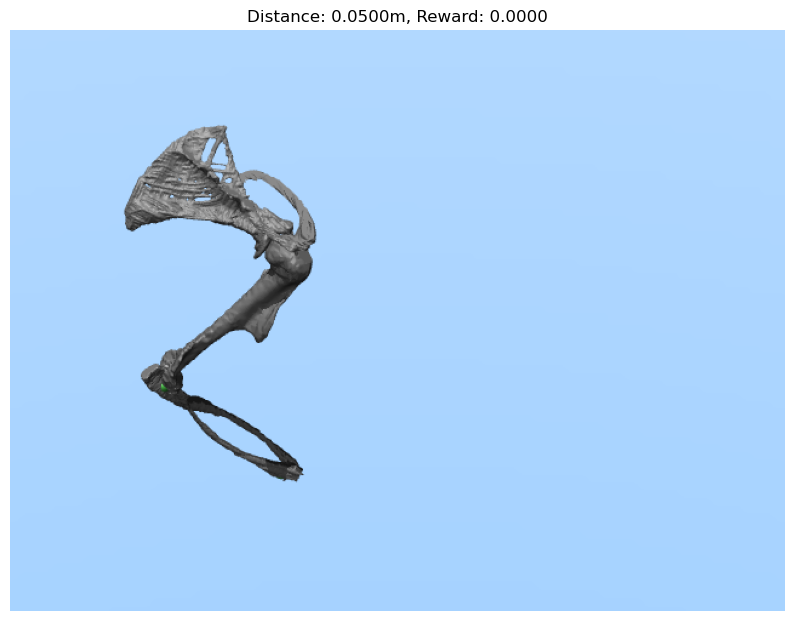

In [ ]:
# Create MjData for rendering
mj_data = mj.MjData(env.mj_model)
mj.mj_forward(env.mj_model, mj_data)

# Render with reward information
render_with_markers(env.mj_model, mj_data, camera="close_profile")

In [ ]:
# Display all possible target positions
target_positions = mouse_reach.MouseEnv.get_target_positions()
print("Available target positions:")
for i, pos in enumerate(target_positions):
    print(f"Position {i}: {pos}")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D visualization of the target positions
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the target positions
x = target_positions[:, 0]
y = target_positions[:, 1]
z = target_positions[:, 2]
ax.scatter(x, y, z, c='r', marker='o', s=100)

# Add labels for each point
for i, (xi, yi, zi) in enumerate(zip(x, y, z)):
    ax.text(xi, yi, zi, f'{i}', fontsize=12)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Target Positions')

plt.show()

In [ ]:
# Test adding a random target
env.add_target(random_target=True)

# Get target position from the site in MuJoCo
mj_data = mj.MjData(env.mj_model)
mj.mj_forward(env.mj_model, mj_data)

target_site_id = env._spec.site("target").id
target_pos_from_site = mj_data.site(target_site_id).xpos
print(f"Target position from MuJoCo site: {target_pos_from_site}")

# Reset environment and render
state = env.reset(jax.random.PRNGKey(0))
render_with_markers(env.mj_model, mj_data, camera="close_profile")